In [1]:
!pip install transformers
!pip install torchtext==0.6

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 84.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 34.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 120.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 89.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 44.6 MB/s eta 0:00:00
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.15.2
    Uninstalling torchtext-0.15.2:
      Successfully uninstalled torchtext-0.15.2


In [2]:
from torchtext.data import Field, TabularDataset, BucketIterator,LabelField
import torch

import random
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True


In [3]:
print(torch.version.cuda)
print(torch.__version__)
import sys
print(sys.version)

print(np.__version__)
print(pd.__version__)

11.8
2.0.1+cu118
3.10.12 (main, Jun  7 2023, 12:45:35) [GCC 9.4.0]
1.22.4
1.5.3


In [4]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [5]:
init_token = tokenizer.cls_token
eos_token = tokenizer.sep_token
pad_token = tokenizer.pad_token
unk_token = tokenizer.unk_token

print(init_token, eos_token, pad_token, unk_token)

init_token_idx = tokenizer.convert_tokens_to_ids(init_token)
eos_token_idx = tokenizer.convert_tokens_to_ids(eos_token)
pad_token_idx = tokenizer.convert_tokens_to_ids(pad_token)
unk_token_idx = tokenizer.convert_tokens_to_ids(unk_token)

print(init_token_idx, eos_token_idx, pad_token_idx, unk_token_idx)


init_token_idx = tokenizer.cls_token_id
eos_token_idx = tokenizer.sep_token_id
pad_token_idx = tokenizer.pad_token_id
unk_token_idx = tokenizer.unk_token_id

print(init_token_idx, eos_token_idx, pad_token_idx, unk_token_idx)

[CLS] [SEP] [PAD] [UNK]
101 102 0 100
101 102 0 100


In [6]:
max_input_length = tokenizer.max_model_input_sizes['bert-base-uncased']
print(max_input_length)

512


In [7]:
def tokenize_and_cut(sentence):
    tokens = tokenizer.tokenize(sentence)
    tokens = tokens[:max_input_length-2]
    return tokens

In [8]:
import pandas as pd

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Load the original dataset
df = pd.read_csv('missom_coded_v1_santosh.csv')
df = df.rename(columns={'label_minority_stress': 'label'})
df = df[['text', 'label']]

empty_cells =  df.isnull().sum()
print(empty_cells)
df.dropna(inplace = True)

empty_cells =  df.isnull().sum()
print(empty_cells)


text     0
label    0
dtype: int64
text     0
label    0
dtype: int64


<ipython-input-8-4c5d34cc9661>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace = True)


In [9]:
from sklearn.model_selection import train_test_split

train_ratio = 0.65
valid_ratio = 0.15
test_ratio = 0.20

train_df, remaining_df = train_test_split(df, test_size=1 - train_ratio, random_state=random.seed(SEED))
valid_df, test_df = train_test_split(remaining_df, test_size=test_ratio/(valid_ratio + test_ratio), random_state=random.seed(SEED))

# Save the dataframes to CSV files
train_df.to_csv('train.csv', index=False)
test_df.to_csv('test.csv', index=False)
valid_df.to_csv('valid.csv', index=False)

In [10]:
TEXT = Field(batch_first = True,
                  use_vocab = False,
                  tokenize = tokenize_and_cut,
                  preprocessing = tokenizer.convert_tokens_to_ids,
                  init_token = init_token_idx,
                  eos_token = eos_token_idx,
                  pad_token = pad_token_idx,
                  unk_token = unk_token_idx)

LABEL = LabelField(dtype = torch.float)

In [11]:
# Load the data
train_data,valid_data, test_data = TabularDataset.splits(
    path= '/content/',
    train='train.csv',
    validation='valid.csv',
    test='test.csv',
    format='csv',
    fields=[('text', TEXT), ('label', LABEL)],
    skip_header=True
)
print('Number of training examples: {}'.format(len(train_data)))
print('Number of Validation examples: {}'.format(len(valid_data)))
print('Number of testing examples: {}'.format(len(test_data)))
print(train_data[0])

Number of training examples: 3762
Number of Validation examples: 868
Number of testing examples: 1159


In [12]:
print(vars(train_data.examples[6]))


{'text': [1045, 1005, 1049, 2570, 1998, 3027, 2213, 3048, 2000, 5899, 1010, 3146, 2012, 1996, 2203, 1997, 2023, 2095, 1998, 2001, 6603, 2054, 1996, 2190, 3182, 1998, 3971, 2000, 2707, 2000, 3985, 6653, 2024, 1012, 1045, 1005, 2310, 2973, 1999, 1037, 2200, 2235, 2237, 2007, 2053, 2490, 4661, 2814, 2040, 4995, 1005, 1056, 9099, 1010, 1998, 2026, 7833, 1012, 2061, 2026, 3716, 2003, 2025, 2172, 1048, 2863, 2080, 1012, 2065, 2151, 1997, 8038, 3363, 2031, 2151, 6040, 2030, 15690, 2009, 1005, 1040, 2022, 4658, 2065, 8038, 3363, 2071, 3745, 1010, 4283, 999], 'label': '0'}


In [13]:
LABEL.build_vocab(train_data)

In [14]:
print(LABEL.vocab.stoi)

defaultdict(None, {'0': 0, '1': 1})


In [15]:
BATCH_SIZE = 4
train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size = BATCH_SIZE,
    device = device,
    sort_key=lambda x: len(x.text),
    sort_within_batch = True
    )

In [16]:
from transformers import BertTokenizer, BertModel
bert = BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [17]:
import torch.nn as nn

class BERTGRUSentiment(nn.Module):
    def __init__(self,
                 bert,
                 hidden_dim,
                 output_dim,
                 n_layers,
                 bidirectional,
                 dropout):

        super().__init__()

        self.bert = bert

        embedding_dim = bert.config.to_dict()['hidden_size']
        self.out = nn.Linear(embedding_dim,output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        with torch.no_grad():
            embedded = self.bert(text)[0]
        output = self.dropout(embedded[:, 0, :])
        output = self.out(output)

        return output


In [18]:
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.25

model = BERTGRUSentiment(bert,
                         HIDDEN_DIM,
                         OUTPUT_DIM,
                         N_LAYERS,
                         BIDIRECTIONAL,
                         DROPOUT)

In [19]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 109,483,009 trainable parameters


In [20]:
for name, param in model.named_parameters():
    if name.startswith('bert'):
        param.requires_grad = False

In [21]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 769 trainable parameters


In [22]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

out.weight
out.bias


In [23]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

In [24]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division
    acc = correct.sum() / len(correct)
    return acc

In [25]:
def train(model, iterator, optimizer, criterion):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for batch in iterator:

        optimizer.zero_grad()

        predictions = model(batch.text).squeeze(1)

        loss = criterion(predictions, batch.label)

        acc = binary_accuracy(predictions, batch.label)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for batch in iterator:

            predictions = model(batch.text).squeeze(1)

            loss = criterion(predictions, batch.label)

            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [26]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [27]:
N_EPOCHS = 10

best_valid_loss = float('inf')

train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    train_accuracies.append(train_acc)
    valid_accuracies.append(valid_acc)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut6-model.pt')

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 55s
	Train Loss: 0.472 | Train Acc: 79.17%
	 Val. Loss: 0.440 |  Val. Acc: 79.61%
Epoch: 02 | Epoch Time: 0m 57s
	Train Loss: 0.437 | Train Acc: 80.55%
	 Val. Loss: 0.418 |  Val. Acc: 80.88%
Epoch: 03 | Epoch Time: 0m 58s
	Train Loss: 0.432 | Train Acc: 80.71%
	 Val. Loss: 0.408 |  Val. Acc: 81.45%
Epoch: 04 | Epoch Time: 0m 57s
	Train Loss: 0.419 | Train Acc: 81.54%
	 Val. Loss: 0.402 |  Val. Acc: 80.99%
Epoch: 05 | Epoch Time: 0m 57s
	Train Loss: 0.419 | Train Acc: 81.16%
	 Val. Loss: 0.399 |  Val. Acc: 82.03%
Epoch: 06 | Epoch Time: 0m 58s
	Train Loss: 0.411 | Train Acc: 81.51%
	 Val. Loss: 0.413 |  Val. Acc: 81.11%
Epoch: 07 | Epoch Time: 0m 57s
	Train Loss: 0.414 | Train Acc: 81.11%
	 Val. Loss: 0.457 |  Val. Acc: 79.61%
Epoch: 08 | Epoch Time: 0m 58s
	Train Loss: 0.417 | Train Acc: 81.22%
	 Val. Loss: 0.391 |  Val. Acc: 83.06%
Epoch: 09 | Epoch Time: 0m 58s
	Train Loss: 0.411 | Train Acc: 81.22%
	 Val. Loss: 0.388 |  Val. Acc: 82.49%
Epoch: 10 | Epoch T

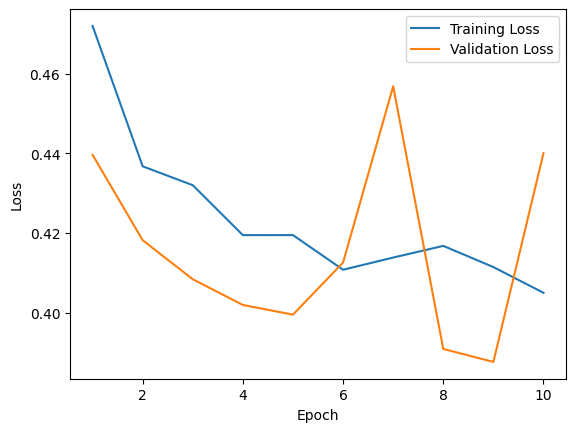

In [28]:
epochs = range(1, N_EPOCHS + 1)

plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

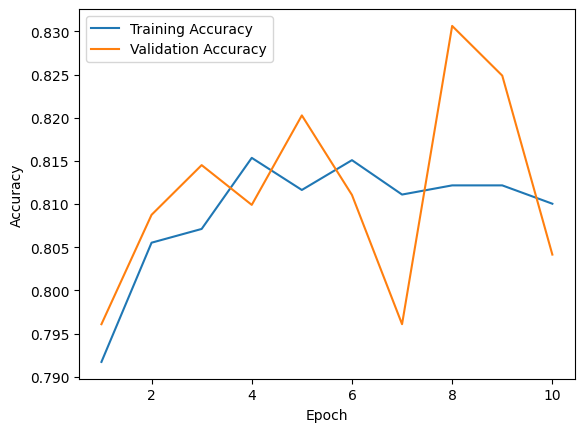

In [29]:
epochs = range(1, N_EPOCHS + 1)

plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [32]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')
def calc_report(model, iterator, criterion):

    epoch_loss = 0
    epoch_acc = 0

    y_pred = []
    y_true = []

    model.eval()

    with torch.no_grad():

        for batch in iterator:


            predictions = model(batch.text).squeeze(1)

            threshold = 0.5
            output_1 = (predictions > threshold).int()
            y_pred.extend(output_1.tolist())
            y_true.extend(batch.label.tolist())

            loss = criterion(predictions, batch.label)
            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

            rep = classification_report(y_true, y_pred, labels=[1,0], digits=2)

    return rep


In [33]:
cal = calc_report(model, test_iterator, criterion)
print(cal)

              precision    recall  f1-score   support

           1       0.95      0.07      0.13       249
           0       0.80      1.00      0.89       910

    accuracy                           0.80      1159
   macro avg       0.87      0.54      0.51      1159
weighted avg       0.83      0.80      0.73      1159



https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/6%20-%20Transformers%20for%20Sentiment%20Analysis.ipynb